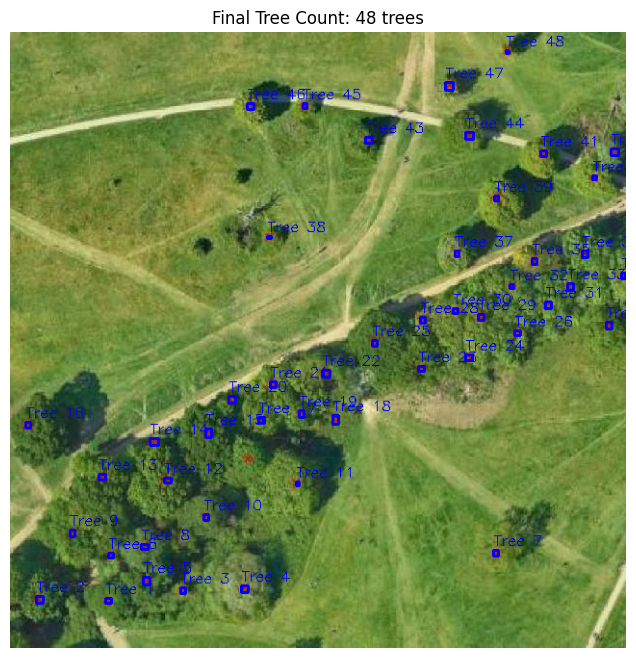

Final Estimated Tree Count: 48 trees


In [ ]:
class ImageSeg:
    def __init__(self, path):
        self.path = path
        self.img = cv2.imread(path)

    def find_red_marks(self):
        # Convert image to HSV color space
        hsv_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)

        # Define color range for detecting red marks
        lower_red1 = np.array([0, 100, 100])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 100])
        upper_red2 = np.array([180, 255, 255])

        # Create a mask for the red color
        mask1 = cv2.inRange(hsv_img, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask1, mask2)

        # Find contours of the red marks
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contours

    def count_red_marks(self):
        contours = self.find_red_marks()
        return len(contours)

    def mark_red_marks(self):
        contours = self.find_red_marks()
        marked_img = np.copy(self.img)
        for i, cnt in enumerate(contours):
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(marked_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw red rectangle
            cv2.putText(marked_img, f'Tree {i+1}', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        return marked_img

    def color_filter(self):
        # Convert image to HSV color space
        hsv_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)

        # Define color range for detecting trees
        lower_bound = np.array([30, 40, 40])  # Lower bound for green color in HSV
        upper_bound = np.array([90, 255, 255])  # Upper bound for green color in HSV

        # Create a mask for the specified color range
        mask = cv2.inRange(hsv_img, lower_bound, upper_bound)

        # Apply the mask to the original image
        filtered_img = cv2.bitwise_and(self.img, self.img, mask=mask)

        return filtered_img

    def preprocess_img(self, img):
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
        edges = cv2.Canny(blurred_img, 50, 150)
        return edges

    def post_process(self, edge_img):
        # Apply morphological operations to clean up the binary image
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        closed_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE, kernel)
        opened_img = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel)
        return opened_img

    def count_trees_without_red_marks(self):
        filtered_img = self.color_filter()
        edge_img = self.preprocess_img(filtered_img)
        processed_img = self.post_process(edge_img)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_img, connectivity=8)
        return num_labels - 1  # Subtract 1 to exclude the background

    def mark_trees_without_red_marks(self):
        filtered_img = self.color_filter()
        edge_img = self.preprocess_img(filtered_img)
        processed_img = self.post_process(edge_img)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_img, connectivity=8)
        marked_img = np.copy(self.img)

        for i in range(1, num_labels):  # Skip the background label
            x, y, w, h, _ = stats[i]
            cv2.rectangle(marked_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw red rectangle
            cv2.putText(marked_img, f'Tree {i}', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        return marked_img

    def count_trees(self):
        red_mark_count = self.count_red_marks()
        if red_mark_count > 0:
            return red_mark_count
        else:
            return self.count_trees_without_red_marks()

    def mark_trees(self):
        red_mark_count = self.count_red_marks()
        if red_mark_count > 0:
            return self.mark_red_marks()
        else:
            return self.mark_trees_without_red_marks()

# Main script
obj = ImageSeg(r"/content/hh_261908_4_174207_4_19_jpg.rf.09f9becfb6b95a264e02a624c2bbf0fb.jpg")
final_count = obj.count_trees()
marked_img = obj.mark_trees()

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
plt.title(f"Final Tree Count: {final_count} trees")
plt.axis('off')
plt.show()

print(f"Final Estimated Tree Count: {final_count} trees")
